# CLIP (Contrastive Language-Image PreTraining)

## 🧠 Introduction to CLIP: Contrastive Language–Image Pretraining

Before we dive into code, it's important to understand **what CLIP is**, **why it matters**, and **how it has changed the game** in multimodal AI.

---

### 🤔 What is CLIP?

CLIP (Contrastive Language–Image Pretraining) is a model developed by OpenAI that can understand images **in natural language terms**. It was trained on **400 million (image, text)** pairs collected from the internet and can perform **zero-shot classification**—meaning it can recognize objects and concepts **without needing fine-tuning** on specific datasets.

Instead of relying on class labels like "dog" or "car," CLIP understands and reasons about images using **natural language descriptions**—a powerful leap in bridging vision and language.

---

### 🔙 The Pre-CLIP Era

Before CLIP, the standard approach for image classification involved training models like:

- **ResNet**
- **VGG**
- **EfficientNet**

These models were trained on datasets like **ImageNet**, which contains 1,000 predefined classes. Performance was typically:

- **Tied to the dataset** (you had to fine-tune on your target dataset)
- **Dependent on labeled data**
- **Lacking generalization** for unseen classes

**Benchmark Scores** (Zero-shot):

- ResNet-50 (ImageNet-trained): ~76% Top-1 accuracy
- Models had **no ability** to generalize to new classes without retraining

---

### 🚀 Enter CLIP: A Paradigm Shift

CLIP introduced a novel idea: **learn to match images and text** through contrastive learning.

#### 🆕 What’s Novel About CLIP?

- Learns **joint embeddings** of images and text
- Can **compare similarity** between image and text representations
- Enables **zero-shot learning** using natural language prompts

#### 📈 Benchmark Performance

- On **ImageNet**, CLIP (ViT-B/32) achieves:
  - **76.2% Top-1 accuracy** in **zero-shot** settings
- Outperforms prior models on **30 out of 32 benchmarks**—without fine-tuning!

---

### 🧪 What You’ll Learn in This Notebook

In this hands-on notebook, we’ll explore how CLIP works and how to use it effectively.

We will:

- Setup
  - ✅ **Set up your machine** to run CLIP
  - 🔎 **Verify installation** and run a quick demo
  - 🧫 Test CLIP on **CIFAR-100**
- Following the bits: From Input to Output
  - 🧼 Understand the **image preprocessing steps**
  - ✍️ Understand the **tokenization of text inputs**
- Deploying via Gradio
  - 🖼️ Build an interactive **Gradio interface**
- 🧩 **Bonus:** Inspecting the **CLIP Model Architecture**

> 📌 Whether you're a researcher, student, or ML enthusiast, this notebook will help you gain an **intuitive and practical understanding** of one of the most impactful vision-language models to date.

Let’s get started! 🚀


## 🔧 Environment Setup

Before we dive into exploring CLIP, we need to set up the environment with the required libraries.

The following commands install:

- **PyTorch 1.7.1** with CUDA 11.0 support
- Common utility libraries: `ftfy`, `regex`, and `tqdm`
- The **official CLIP repository** from OpenAI via Git

These commands are intended to be run in your terminal or a shell cell:

```bash
# Install PyTorch and torchvision with CUDA 11.0
conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0

# Install helper packages
pip install ftfy regex tqdm

# Install the CLIP library directly from GitHub
pip install git+https://github.com/openai/CLIP.git



In [1]:
## First, install PyTorch 1.7.1 (or later) and torchvision, as well as small additional dependencies, and then install this repo as a Python package. On a CUDA GPU machine, the following will do the trick:
# $ conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
# $ pip install ftfy regex tqdm
# $ pip install git+https://github.com/openai/CLIP.git


Replace cudatoolkit=11.0 above with the appropriate CUDA version on your machine or cpuonly when installing on a machine without a GPU.

## ✅ Verifying Installation and Running a Quick Demo

To verify that CLIP was installed successfully, we run an official demo from [OpenAI's CLIP GitHub repository](https://github.com/openai/CLIP). This script loads the CLIP model and runs a simple zero-shot image classification task.

### What's happening in this cell?

- The CLIP model `ViT-B/32` is loaded along with its corresponding preprocessing transform.
- An image (`CLIP.png`) is preprocessed and passed into the model.
- A list of text prompts is tokenized.
- The image and text are encoded into feature vectors using CLIP’s vision and language encoders.
- The model computes similarity scores (logits) between the image and the text features.
- A softmax is applied to get class probabilities, showing how likely the image corresponds to each text prompt.

### Output

The printed output shows the model's probability distribution over the candidate text labels. For example:

Label probs: [[0.9927937 0.00421068 0.00299572]]

This indicates that the model strongly associates the image with the first label ("a diagram")—demonstrating zero-shot classification in action.

In [2]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(f"Running on {device}")
model, preprocess = clip.load("ViT-B/32", device=device)  # loads the model and the TorchVision transform needed by the model

image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device) #Returns a LongTensor containing tokenized sequences of given text input(s). 

with torch.no_grad():
    image_features = model.encode_image(image) #Given a batch of images, returns the image features encoded by the vision portion of the CLIP model.
    text_features = model.encode_text(text) #Given a batch of text tokens, returns the text features encoded by the language portion of the CLIP model.
    
    logits_per_image, logits_per_text = model(image, text) #Given a batch of images and a batch of text tokens, returns two Tensors, containing the logit scores corresponding to each image and text input. 
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

/home/nikko/anaconda3/envs/clip/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on cuda
Label probs: [[0.9927   0.00432  0.003016]]


## 🖼️ Visualizing CLIP's Predictions

In this section, we enhance the previous demo by visualizing the input image and displaying the predicted label probabilities in a sorted table format.

### What’s New?

- **Matplotlib** is used to display the input image directly in the notebook.
- **Pandas** is used to tabulate and sort the label predictions, making the output more interpretable.

### Step-by-Step:

1. **Image Display**:  
   The image is shown inline using `matplotlib.pyplot`. This helps in associating the predictions with the actual visual content.

2. **Prediction Table**:  
   CLIP compares the image against a list of text labels and computes their similarity. These similarities are turned into probabilities using `softmax`.

3. **Sorted Output**:  
   The results are organized into a DataFrame and sorted in descending order of confidence, making it easy to identify what CLIP thinks the image most likely represents.



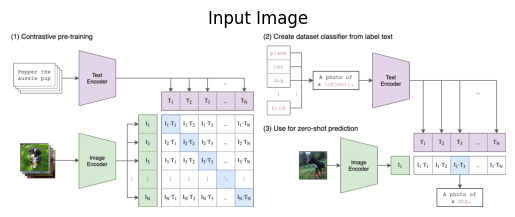

,Label,Probability
0,a diagram,0.992676
1,a dog,0.004318
2,a cat,0.003016


In [3]:
# import torch
# import clip
# from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Enable inline plotting in Jupyter
%matplotlib inline

# Load the model and preprocessing
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load("ViT-B/32", device=device)

# Load and preprocess the image
image_path = "CLIP.png"
raw_image = Image.open(image_path)
image = preprocess(raw_image).unsqueeze(0).to(device)

# Define text labels
labels = ["a diagram", "a dog", "a cat"]
text = clip.tokenize(labels).to(device)

# Encode image and text, then calculate similarity
with torch.no_grad():
    # image_features = model.encode_image(image)
    # text_features = model.encode_text(text)
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()[0]

# Display the image in the notebook
plt.imshow(raw_image)
plt.axis('off')
plt.title("Input Image")
plt.show()

# Create and display a sorted table
df = pd.DataFrame({
    "Label": labels,
    "Probability": probs
}).sort_values(by="Probability", ascending=False).reset_index(drop=True)

df.style.set_properties(**{'text-align': 'left'})


## show available Vision Backbone models

In [4]:
# show available models
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

## 🧫 A Quick Overview of CIFAR-100

[CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) is a benchmark dataset widely used in machine learning and computer vision research.

It contains:

- **60,000 color images** with size **32×32 pixels**
- **100 different classes**, each containing **6000 images**
- Each image belongs to a **fine label** (e.g., "maple tree", "rocket") and also falls under a **coarse category** (e.g., "trees", "vehicles")

### 📂 Dataset Breakdown:

- **Training set**: 50,000 images
- **Test set**: 10,000 images
- Each class has 500 training images and 100 test images

### 🧠 Why Use CIFAR-100?

- It’s **small** yet **challenging**, making it ideal for testing lightweight and efficient models.
- Its **100 diverse classes** test a model’s ability to **generalize** across many categories.
- Perfect for exploring **zero-shot learning** using models like CLIP, which have never seen CIFAR-100 during training.

---

In this notebook, we'll use CIFAR-100 to evaluate CLIP's **zero-shot classification performance** and explore how well it can generalize to datasets it was not explicitly trained on.


## 🧪 Testing CLIP on CIFAR-100

In this section, we evaluate CLIP’s zero-shot classification ability using the **CIFAR-100** dataset. Unlike our previous toy example, CIFAR-100 introduces more diverse and challenging image classes.

### Workflow Breakdown:

1. **Dataset Preparation**:
   - We use the test split of the CIFAR-100 dataset, which contains 100 object classes.
   - A random sample is selected and displayed to observe the model's performance visually.

2. **Prompt Engineering**:
   - Each class label is wrapped with the phrase: `"a photo of a <class>"`.
   - This matches the training style of CLIP, which was trained on text-image pairs with natural language prompts.

3. **Feature Extraction**:
   - The selected image and all class prompts are encoded using CLIP's image and text encoders.
   - Feature vectors are normalized before similarity is computed.

4. **Similarity & Prediction**:
   - Cosine similarity (scaled and passed through a softmax) is computed between the image and all 100 class prompts.
   - The top-5 most probable classes are extracted and displayed.


### Zero-Shot Prediction
The code below performs zero-shot prediction using CLIP. This example takes an image from the CIFAR-100 dataset, and predicts the most likely labels among the 100 textual labels from the dataset.

As seen, CLIP generalizes quite well even on datasets it wasn’t explicitly trained on — showcasing the power of zero-shot learning using contrastive pretraining.


Files already downloaded and verified
------------------------------------------------------------
Input Image
Random index: 4584
Image object: <PIL.Image.Image image mode=RGB size=32x32 at 0x7F97082CAB80>
Class ID: 68
Class Name: road
Image size: (32, 32)


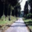

------------------------------------------------------------

Top predictions:

            road: 49.93%
      lawn_mower: 7.42%
           plain: 6.15%
       pine_tree: 5.60%
          forest: 3.67%


In [5]:
import os
import clip
import torch
import random
from torchvision.datasets import CIFAR100


def show_random_cifar100_sample(cifar100,rand_index):
    
    # Get image and class_id
    image, class_id = cifar100[rand_index]
    
    # Print info
    print(f"Random index: {rand_index}")
    print("Image object:", image)
    print("Class ID:", class_id)
    print("Class Name:", cifar100.classes[class_id])
    print("Image size:", image.size)
    
    # Display image in Jupyter
    display(image)
    # Display in browser
    image.show


# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load('ViT-B/32', device)

# Download the dataset. uncomment if first time
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

print("-"*60)
print("Input Image")

# Pick a random index
rand_index = random.randint(0, len(cifar100) - 1)
show_random_cifar100_sample(cifar100, rand_index)


# Prepare the inputs
image, class_id = cifar100[rand_index]
image_input = preprocess(image).unsqueeze(0).to(device)

# text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)
text_inputs = clip.tokenize([f"a photo of a {c}" for c in cifar100.classes]).to(device)

# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("-"*60)
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")

---
# 🔍 Understanding CLIP: Connecting Vision and Language

CLIP (Contrastive Language-Image Pretraining) is a powerful model that bridges the gap between visual and textual information. It learns to understand images and text in a shared embedding space, allowing it to perform tasks like zero-shot image classification. This section takes you through the entire process of how CLIP tokenizes, encodes, and performs inference to predict the most likely label for an image.

![CLIP Model](CLIP.png)

---
## 🧱 Tokenization: From Raw to Tokens

Before CLIP can understand and process inputs, both **text** and **images** need to be transformed into numerical formats — a process known as **tokenization**.

CLIP has two separate tokenization pathways:
- ✍️ **Text Tokenization** using a Byte Pair Encoding (BPE) tokenizer

        text_inputs = clip.tokenize(["label1", "label2", ..., "labeln"]).to(device)

    🔢 **Expected output** is a tensor with shape `torch.Size([n, 77])`  
    - `n` refers to the number of text prompts (e.g., class labels)  
    - `77` is the **maximum token length** defined by CLIP's tokenizer


- 🖼️ **Image Tokenization** via preprocessing
    

        image_input = preprocess(image).unsqueeze(0).to(device)
        

    Images go through a standardized pipeline to match the model's expected input:

    1. **Resize** – Scales the image so the shortest side is 224 pixels.
    2. **CenterCrop** – Crops the central 224×224 region.
    3. **ToTensor** – Converts the image to a tensor and scales pixel values to [0.0, 1.0].
    4. **Normalize** – Standardizes values based on the dataset’s mean and std.

    🔢 **Expected output** is a tensor with shape `torch.Size([1, 3, 224, 224])`  
    - `1` — Batch size (we're passing a single image)  
    - `3` — Number of color channels (RGB)  
    - `224` — Height of the image in pixels  
    - `224` — Width of the image in pixels  

    This format ensures compatibility with CLIP, which expects images to be preprocessed to a standardized input size.

---

## 🧠 Semantic Representations: From Tokens to Features

Now that we've prepared and preprocessed both our image and text inputs, it's time to understand how CLIP transforms them into semantic embeddings — the backbone of how CLIP links vision and language.

CLIP uses two separate encoders:


- A **text encoder** (a Transformer) that converts tokenized text inputs into feature vectors in the same embedding space.

        text_features = model.encode_text(text_inputs)

    🔢 **Expected output shapes**: `text_features`: `torch.Size([n, 512])`  
        - `n` — number of text inputs (typically the number of classes)  
        - `512` — the dimensionality of the CLIP text embedding  

- An **image encoder** (typically a Vision Transformer or ResNet) that converts images into fixed-length feature vectors.

        image_features = model.encode_image(image_input)

    🔢 **Expected output shapes**: `image_features`: `torch.Size([1, 512])`  
        - `1` — corresponds to the single input image (batch size)  
        - `512` — the dimensionality of the CLIP image embedding



---

## 🔎 Inference: From Features to Probability

Once we’ve obtained the **semantic representations** (feature vectors) for both the image and the text, it’s time to compare them and **generate predictions**.

CLIP performs **zero-shot classification** by measuring how similar the image feature is to all text features in the shared embedding space.

### Steps:

1. **Normalize the feature vectors**:
    ```python
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features  /= text_features.norm(dim=-1, keepdim=True)
    ```
    ✅ **Normalize** both vectors to unit length.  
    This ensures we're comparing directions rather than magnitudes — essentially turning the dot product into **cosine similarity**.

2. **Compute similarity scores**:
    ```python
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    ```
    🧠 **Compute similarity scores**.  
    We take:
    - `image_features @ text_features.T`: the dot product of the image and text features to get raw similarity scores 
    - `100 * similarity_scores`: scale by 100 (a trick from CLIP authors to stabilize softmax),
    - `scaled_similarity_scores.softmax(dim=-1)`:  apply softmax to turn it into probabilities. The dim=-1 argument ensures that softmax is applied across the last dimension (i.e., for each of the N text labels) 

    🔢 **Expected Output**: The `similarity` tensor will have shape `torch.Size([1, N])`
    - Where `N` is the number of class labels (e.g., 100 for CIFAR-100).  
    - Each element in the vector corresponds to the model’s **confidence** that the image matches that text description.


3. **Select top predictions**:
    ```python
    values, indices = similarity[0].topk(5)
    ```
    This line extracts the **top 5 most probable class labels** for the given image input.


#### Inference Steps Summary
- We **normalize** the feature vectors to ensure we're comparing their directions.
- We **compute similarity scores** using cosine similarity, turning them into probabilities.
- We **pick the top 5 labels** with the highest probability to identify what the image most likely represents.




# Visualization of **Image Tokenization** via preprocessing


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


----------------------------------------------------------------------------------------------------
Preprocessing the image...


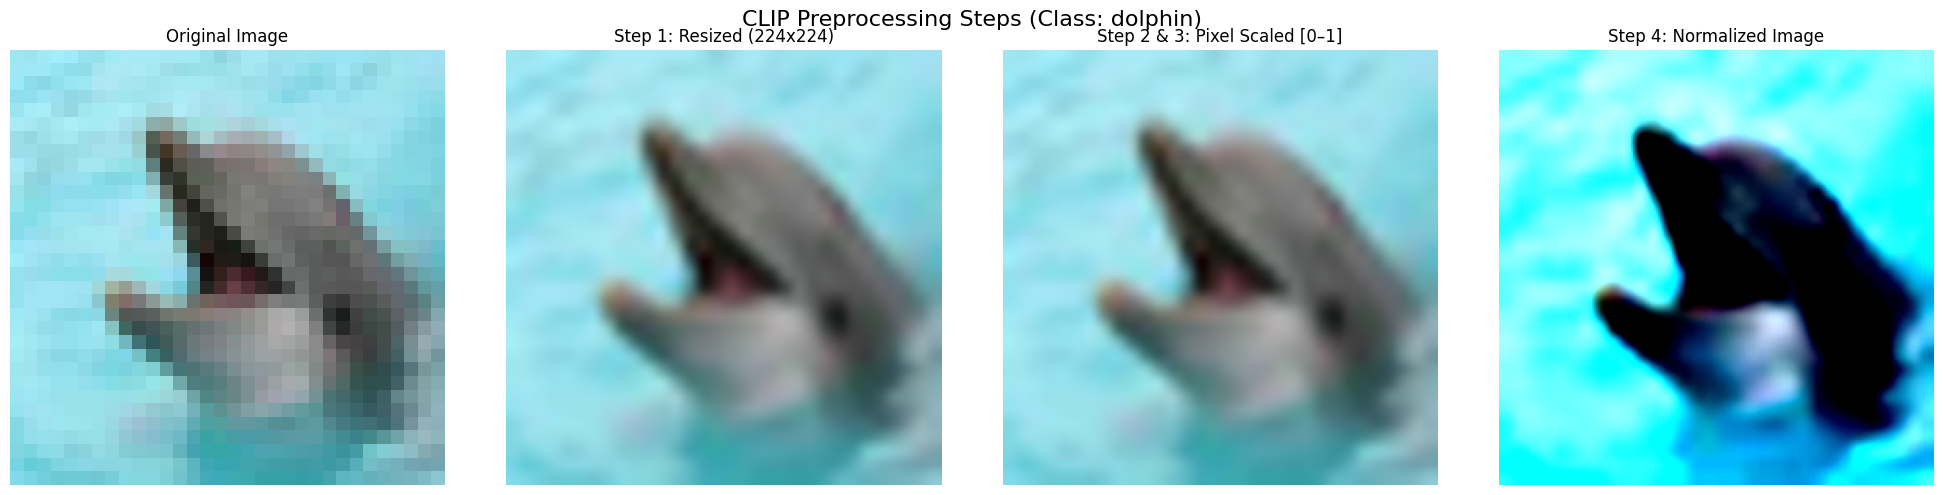

Final tensor shape: torch.Size([3, 224, 224])
The last step of image preprocessing is converting the image into tensor
image tensor shape:  torch.Size([1, 3, 224, 224])
tokenize image:  tensor([[[[0.5289, 0.5289, 0.5289,  ..., 0.5289, 0.5289, 0.5289],
          [0.5289, 0.5289, 0.5289,  ..., 0.5289, 0.5289, 0.5289],
          [0.5289, 0.5289, 0.5289,  ..., 0.5289, 0.5289, 0.5289],
          ...,
          [0.1347, 0.1347, 0.1347,  ..., 0.2515, 0.2515, 0.2515],
          [0.1347, 0.1347, 0.1347,  ..., 0.2661, 0.2661, 0.2661],
          [0.1493, 0.1493, 0.1493,  ..., 0.2807, 0.2807, 0.2807]],

         [[1.7147, 1.7147, 1.7147,  ..., 1.6247, 1.6247, 1.6247],
          [1.7147, 1.7147, 1.7147,  ..., 1.6247, 1.6247, 1.6247],
          [1.7147, 1.7147, 1.7147,  ..., 1.6247, 1.6247, 1.6247],
          ...,
          [1.5196, 1.5046, 1.5046,  ..., 1.2795, 1.2795, 1.2795],
          [1.5196, 1.5046, 1.5046,  ..., 1.2945, 1.2945, 1.2945],
          [1.5346, 1.5046, 1.5196,  ..., 1.3095, 1.3095,

In [6]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets
import random

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)  # loads the model and the TorchVision transform needed by the model


# CLIP normalization constants
mean = np.array([0.48145466, 0.4578275, 0.40821073])
std = np.array([0.26862954, 0.26130258, 0.27577711])

def clip_preprocess_manual(pil_image, class_label=None, visualize=True):
    """
    Full CLIP-style preprocessing: Resize → Center Crop → Scale → Normalize → To Tensor.
    Optionally displays each step for visualization.
    Returns the final preprocessed tensor.
    """
    # Step 1: Resize
    resized = pil_image.resize((224, 224))

    # Step 2: Center Crop (technically redundant here)
    cropped = resized.crop((0, 0, 224, 224))

    # Step 3: Scale pixels to [0, 1]
    img_np_scaled = np.array(cropped).astype(np.float32) / 255.0

    # Step 4: Normalize
    img_np_normalized = (img_np_scaled - mean) / std

    # Step 5: Convert to tensor (C, H, W)   
    img_tensor = torch.tensor(img_np_normalized).permute(2, 0, 1)

    # Optional visualization
    if visualize:
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        axes[0].imshow(pil_image)
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        axes[1].imshow(resized)
        axes[1].set_title("Step 1: Resized (224x224)")
        axes[1].axis("off")

        axes[2].imshow(img_np_scaled)
        axes[2].set_title("Step 2 & 3: Pixel Scaled [0–1]")
        axes[2].axis("off")

        # Step 4 Visualization: Reverse normalization just for display
        # normalized_vis = np.clip(img_np_normalized * std + mean, 0, 1)
        # axes[3].imshow(normalized_vis)
        axes[3].imshow(img_np_normalized)
        axes[3].set_title("Step 4: Normalized Image")
        axes[3].axis("off")

        title = "CLIP Preprocessing Steps"
        if class_label is not None:
            title += f" (Class: {class_label})"
        plt.suptitle(title, fontsize=16)
        plt.tight_layout()
        plt.show()

    return img_tensor


# Load CIFAR-100
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

for iter in range(1):
    print("-"*100)
    print("Preprocessing the image...")
    idx = random.randint(0, len(cifar100)-1)
    image, class_id = cifar100[idx]
    pil_image = Image.fromarray(np.array(image))

    # Apply and visualize
    tensor = clip_preprocess_manual(pil_image, class_label=cifar100.classes[class_id])
    print("Final tensor shape:", tensor.shape)

    # Pick a random index

    # Prepare the inputs
    image, class_id = cifar100[idx]
    image_input = preprocess(image).unsqueeze(0).to(device)
    print("The last step of image preprocessing is converting the image into tensor")
    print("image tensor shape: ", image_input.shape)
    print("tokenize image: ", image_input)


    # text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)
    text_inputs = clip.tokenize([f"a photo of a {c}" for c in cifar100.classes]).to(device)


    # print("Predicting...")

    # Calculate features
    # with torch.no_grad():
    #     image_features = model.encode_image(image_input)
    #     text_features = model.encode_text(text_inputs)

    # # Pick the top 5 most similar labels for the image
    # image_features /= image_features.norm(dim=-1, keepdim=True)
    # text_features /= text_features.norm(dim=-1, keepdim=True)
    # similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    # values, indices = similarity[0].topk(5)

    # # Print the result
    # print("\nTop predictions:\n")
    # for value, index in zip(values, indices):
    #     print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 ----------------------------------------------------------------------------------------------------
🧱 Tokenization: From Raw to Tokens

Preprocessing the image...


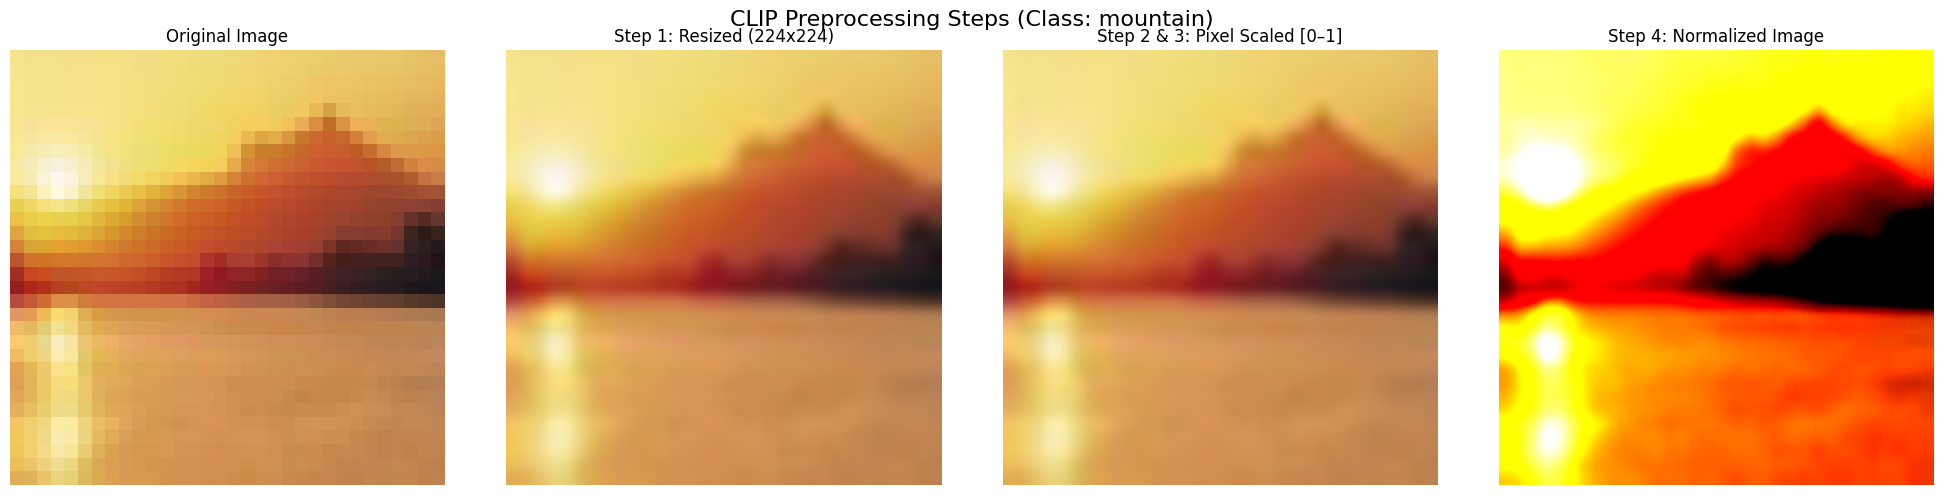

image tensor shape:  torch.Size([1, 3, 224, 224])
tokenize image:  tensor([[[[ 1.7844,  1.7844,  1.7844,  ...,  1.5654,  1.5654,  1.5654],
          [ 1.7844,  1.7844,  1.7844,  ...,  1.5654,  1.5654,  1.5654],
          [ 1.7844,  1.7844,  1.7844,  ...,  1.5654,  1.5654,  1.5654],
          ...,
          [ 1.4924,  1.4924,  1.4924,  ...,  0.9522,  0.9522,  0.9522],
          [ 1.4924,  1.4924,  1.4924,  ...,  0.9522,  0.9522,  0.9522],
          [ 1.4924,  1.4924,  1.4924,  ...,  0.9522,  0.9522,  0.9522]],

         [[ 1.6697,  1.6697,  1.6697,  ...,  1.0844,  1.0844,  1.0844],
          [ 1.6697,  1.6697,  1.6697,  ...,  1.0844,  1.0844,  1.0844],
          [ 1.6697,  1.6697,  1.6697,  ...,  1.0844,  1.0844,  1.0844],
          ...,
          [ 0.8142,  0.8292,  0.8292,  ...,  0.2139,  0.2139,  0.2139],
          [ 0.7992,  0.8142,  0.8142,  ...,  0.2139,  0.2139,  0.2139],
          [ 0.7992,  0.8142,  0.8142,  ...,  0.2139,  0.2139,  0.2139]],

         [[ 0.4964,  0.4964,  0.496

In [7]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets
import random
import clip
import os

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)  # loads the model and the TorchVision transform needed by the model


# CLIP normalization constants (used for manual preprocessing)
mean = np.array([0.48145466, 0.4578275, 0.40821073])
std = np.array([0.26862954, 0.26130258, 0.27577711])

def clip_preprocess_manual(pil_image, class_label=None, visualize=True):
    """
    Full CLIP-style preprocessing: Resize → Center Crop → Scale → Normalize → To Tensor.
    Optionally displays each step for visualization.
    Returns the final preprocessed tensor.
    """
    # Step 1: Resize
    resized = pil_image.resize((224, 224))

    # Step 2: Center Crop (technically redundant here)
    cropped = resized.crop((0, 0, 224, 224))

    # Step 3: Scale pixels to [0, 1]
    img_np_scaled = np.array(cropped).astype(np.float32) / 255.0

    # Step 4: Normalize
    img_np_normalized = (img_np_scaled - mean) / std

    # Step 5: Convert to tensor (C, H, W)   
    img_tensor = torch.tensor(img_np_normalized).permute(2, 0, 1)

    # Optional visualization
    if visualize:
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        axes[0].imshow(pil_image)
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        axes[1].imshow(resized)
        axes[1].set_title("Step 1: Resized (224x224)")
        axes[1].axis("off")

        axes[2].imshow(img_np_scaled)
        axes[2].set_title("Step 2 & 3: Pixel Scaled [0–1]")
        axes[2].axis("off")

        axes[3].imshow(img_np_normalized)
        axes[3].set_title("Step 4: Normalized Image")
        axes[3].axis("off")

        title = "CLIP Preprocessing Steps"
        if class_label is not None:
            title += f" (Class: {class_label})"
        plt.suptitle(title, fontsize=16)
        plt.tight_layout()
        plt.show()

    return img_tensor


# Load CIFAR-100
cifar100 = datasets.CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

# Tokenization and preprocessing loop
for iter in range(1):
    print("\n","-" * 100)
    print("🧱 Tokenization: From Raw to Tokens")
    print("\nPreprocessing the image...")

    # Pick a random image from CIFAR-100
    idx = random.randint(0, len(cifar100) - 1)
    image, class_id = cifar100[idx]
    pil_image = Image.fromarray(np.array(image))

    # CLIP manual preprocessing
    tensor = clip_preprocess_manual(pil_image, class_label=cifar100.classes[class_id])
    # print("Final tensor shape:", tensor.shape)

    # Step 2: Image Preprocessing for CLIP model
    image_input = preprocess(image).unsqueeze(0).to(device)
    print("image tensor shape: ", image_input.shape)
    print("tokenize image: ", image_input)


    # Step 3: CLIP Text Tokenization (text inputs for CIFAR-100 classes)
    t_inputs = [f"a photo of a {c}" for c in cifar100.classes]
    text_inputs = clip.tokenize(t_inputs).to(device)
    print("\nTokenizing the text inputs...")
    print("Tokenized shape:", text_inputs.shape)
    print(f"Sample: token for '{t_inputs[0]}'")
    print(text_inputs[0])




    # Step 4: Semantic Feature Extraction (text and image)
    print("\n","-" * 100)
    print("🧠 Semantic Representations: From Tokens to Features")
    print("Extracting features using the model...")
    print("Convert from tokens to features...")
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)
        print("Shape of image_feature:", image_features.shape)
        print("Shape of text_features:", text_features.shape)



    print("\n","-" * 100)
    print("🔎 Inference: From Features to Probability")
    # Normalize the features
    print("Computing for Similirity Matrix")
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Compute the similarity between image and text features
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    print("Similiarity Score shape:", similarity.shape)
    print("Similiarity Score:")
    
    print(similarity)

    print("\n")
    print(t_inputs)
    

    values, indices = similarity[0].topk(5)



    # Print the top predictions
    print("\nTop predictions:\n")
    for value, index in zip(values, indices):
        print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")


### 🔤 Tokenizing Text Inputs

CLIP expects input text in tokenized form using its custom tokenizer, which is based on byte-pair encoding (BPE). In this step, we convert human-readable prompts (like `"a photo of a cat"`) into token IDs that the model understands. These are later passed to the text encoder for feature extraction.


In [8]:
import clip

# Example: user-defined labels or prompts
prompts = ["a photo of a cat", "a photo of a dog", "a diagram"]

# Tokenize the text inputs using CLIP's built-in tokenizer
text_tokens = clip.tokenize(prompts)

# Print tokenized results
for i, prompt in enumerate(prompts):
    print("-"*100)
    print(f"{i+1}. prompt = \"{prompt}\"")
    print(f"   after performing clip.tokenize(\"{prompt}\"), it will become a tensor with shape {text_tokens[i].shape}")
    print("  ", text_tokens[i], "\n")


print("-"*100)
print(f"In summary, the tokenize text input {prompts} becomes:")
print("Tokenized shape:", text_tokens.shape)
print("Tokens:\n", text_tokens)


----------------------------------------------------------------------------------------------------
1. prompt = "a photo of a cat"
   after performing clip.tokenize("a photo of a cat"), it will become a tensor with shape torch.Size([77])
   tensor([49406,   320,  1125,   539,   320,  2368, 49407,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0]) 

----------------------------------------------------------------------------------------------------
2. prompt = "a photo of a dog"
   after performing 

## 🌐 CLIP Zero-Shot Classifier with Gradio

This cell launches an interactive web app using **Gradio** to demonstrate CLIP's **zero-shot classification** capabilities.

### 🛠️ Features:

- **Image Upload** – Provide any image (e.g., object, diagram, sketch).
- **Custom Labels** – Input comma-separated textual prompts like `"a cat, a dog, a diagram"`.
- **Zero-Shot Inference** – CLIP computes image–text similarity without retraining!
- **Visual Output** – Displays predicted labels with confidence bars.

> This UI showcases the true power of CLIP: its ability to generalize to **unseen classes** just by comparing visual and textual embeddings.

### 🚀 Try it out!
1. Upload an image.
2. Type labels like: `a spaceship, a flower, a face`.
3. Click **Classify** and see the ranked predictions instantly.


In [9]:
# 🛠️ Setup
# !pip install -q gradio torch ftfy regex tqdm git+https://github.com/openai/CLIP.git matplotlib

# 📦 Imports
import gradio as gr
import torch
import clip
from PIL import Image
import numpy as np

# 🚀 Load CLIP Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# 🔍 Prediction Function
def predict(image, label_text):
    labels = [label.strip() for label in label_text.split(",") if label.strip()]
    if not image or not labels:
        return []

    # Preprocess inputs
    image_input = preprocess(image).unsqueeze(0).to(device)
    text_inputs = clip.tokenize(labels).to(device)

    # Run model
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)
        logits_per_image, _ = model(image_input, text_inputs)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()[0]

    # Create table with bar visualization
    results = []
    for label, prob in zip(labels, probs):
        bar = f'<div style="background-color:#4caf50;width:{prob*100:.1f}%;height:20px;"></div>'
        results.append([label, f"{prob*100:.2f}%", bar])
    return results


# 🎨 Gradio Interface
with gr.Blocks() as demo:
    gr.Markdown("## 🖼️ CLIP Zero-Shot Classifier")
    
    with gr.Row():
        image = gr.Image(type="pil", label="Upload Image")
        label_text = gr.Textbox(lines=2, label="Enter comma-separated labels",
                                placeholder="e.g., a cat, a dog, a diagram")
    
    submit = gr.Button("Classify")
    
    output = gr.Dataframe(headers=["Label", "Probability", "Confidence Bar"],
                          datatype=["str", "str", "html"],
                          row_count=5,
                          interactive=False)

    submit.click(fn=predict, inputs=[image, label_text], outputs=output)

demo.launch(share=True)


Running on local URL:  http://127.0.0.1:7862
Running on public URL: https://a86e676046f6b0d9f3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## 🧠 CLIP Model Architecture Breakdown

This section explores the internal architecture of the CLIP model (`ViT-B/32`):

- **🔍 Vision Encoder Layers**: Shows the vision transformer responsible for processing images.
- **📝 Text Encoder Layers**: Displays the transformer used to process tokenized text prompts.
- **🏗️ Overall Model Structure**: Prints the complete CLIP model, combining both the vision and text encoders along with projection layers.

Use this cell to inspect how CLIP handles visual and textual input in a unified embedding space.


In [10]:
# 🧠 CLIP Model Architecture Inspection

# Ensure the model is loaded
device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load("ViT-B/32", device=device)

# 🔍 Vision Encoder
print("\n🔍 Vision Encoder Layers:")
print("="*30)
print(model.visual)  # This contains the vision transformer (ViT)

# 📝 Text Encoder
print("\n📝 Text Encoder Layers:")
print("="*30)
print(model.transformer)  # This contains the text transformer layers

# 🏗️ Full CLIP Architecture
print("\n🏗️ Overall CLIP Model Architecture:")
print("="*30)
print(model)



🔍 Vision Encoder Layers:
VisionTransformer(
  (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
  (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (resblocks): Sequential(
      (0): ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=768, out_features=768, bias=True)
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): QuickGELU()
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
      (1): ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=768, out_features=768, bias=True)
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affin